In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('inventory.db')  # or use full path if needed

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)

                   name
0       begin_inventory
1         end_inventory
2             purchases
3       purchase_prices
4                 sales
5        vendor_invoice
6  vendor_sales_summary


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [6]:
#creating database connection
conn=sqlite3.connect('inventory.db')

#fetching vendor summary data
df=pd.read_sql_query("select * from vendor_sales_summary",conn)
df.head()

,VendorNumber,VendorName,Brand,Description,PurchasePrice,actualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesPurchaseRatio
0,3960.0,DIAGEO NORTH AMERICA INC,4261.0,Capt Morgan Spiced Rum,16.17,22.99,1750.0,95004.0,1536214.68,19486.0,428528.14,41432.16,35804.05,257032.07,-1107686.54,-258.486302,0.012684,0.278951
1,1128.0,BROWN-FORMAN CORP,1233.0,Jack Daniels No 7 Black,26.27,36.99,1750.0,57735.0,1516698.45,9080.0,326789.20,61614.88,16683.12,68601.68,-1189909.25,-364.121351,0.005987,0.215461
2,4425.0,MARTIGNETTI COMPANIES,3405.0,Tito's Handmade Vodka,23.19,28.99,1750.0,62385.0,1446708.15,9052.0,270781.48,50459.13,16631.68,144929.24,-1175926.67,-434.271454,0.006257,0.187171
3,17035.0,PERNOD RICARD USA,8068.0,Absolut 80 Proof,18.24,24.99,1750.0,75385.0,1375022.40,10243.0,264494.57,45628.33,18819.83,123780.22,-1110527.83,-419.867913,0.007449,0.192357
4,3960.0,DIAGEO NORTH AMERICA INC,3545.0,Ketel One Vodka,21.89,29.99,1750.0,55834.0,1222206.26,11765.0,354214.35,51029.09,21616.83,257032.07,-867991.91,-245.047077,0.009626,0.289816


## Exploratory Data Analysis
1. Previously  we examined the various tables in the database to identify key varibales ,understand their relationships,and determine which ones should be included in the final analysis.
2. In this phase of EDA,we will analyze the resultant table to gain insights into the distribution of each column.This will helps us understand data patterns ,identify anomalies and ensure data quality before proceeding with further analysis.

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,8488.0,1.015248e+04,17720.225926,2.00,3664.000000,7153.000000,9552.000000,1.733570e+05
Brand,8488.0,1.760145e+04,13005.736820,58.00,5296.750000,17435.000000,24981.250000,9.063100e+04
PurchasePrice,8488.0,2.181690e+01,105.650429,0.36,6.800000,10.270000,18.250000,5.681810e+03
actualPrice,8488.0,3.210286e+01,144.021897,0.49,10.990000,15.990000,26.990000,7.499990e+03
Volume,8488.0,8.544712e+02,615.340956,50.00,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,8488.0,1.660781e+03,5378.229838,1.00,24.000000,228.500000,1173.500000,1.548320e+05
TotalPurchaseDollars,8488.0,1.548644e+04,55475.671606,0.71,342.720000,2822.150000,12407.625000,1.536215e+06
TotalSalesQuantity,8488.0,2.787056e+02,938.852738,0.00,3.000000,33.000000,197.000000,2.752100e+04
TotalSalesDollars,8488.0,3.763193e+03,13092.990336,0.00,57.975000,633.490000,3045.020000,4.285281e+05
TotalSalesPrice,8488.0,1.834184e+03,4135.806588,0.00,22.990000,359.820000,1805.192500,6.161488e+04


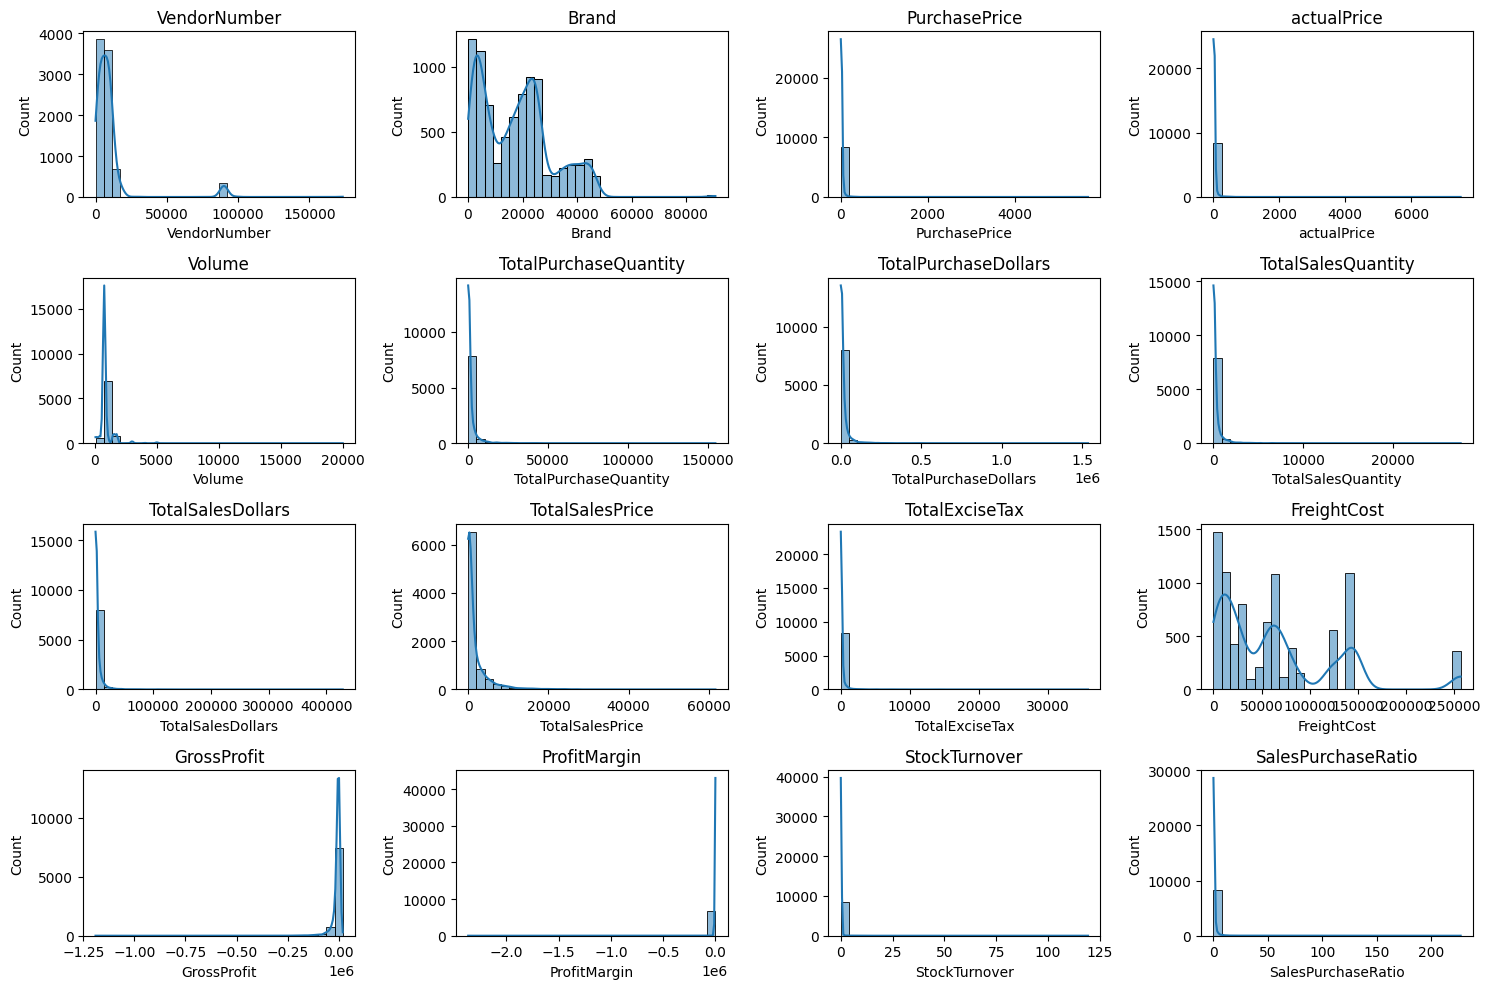

In [12]:
#Distribution plpts for Numerical Values
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i ,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
    plt.tight_layout()
plt.show()
    
    

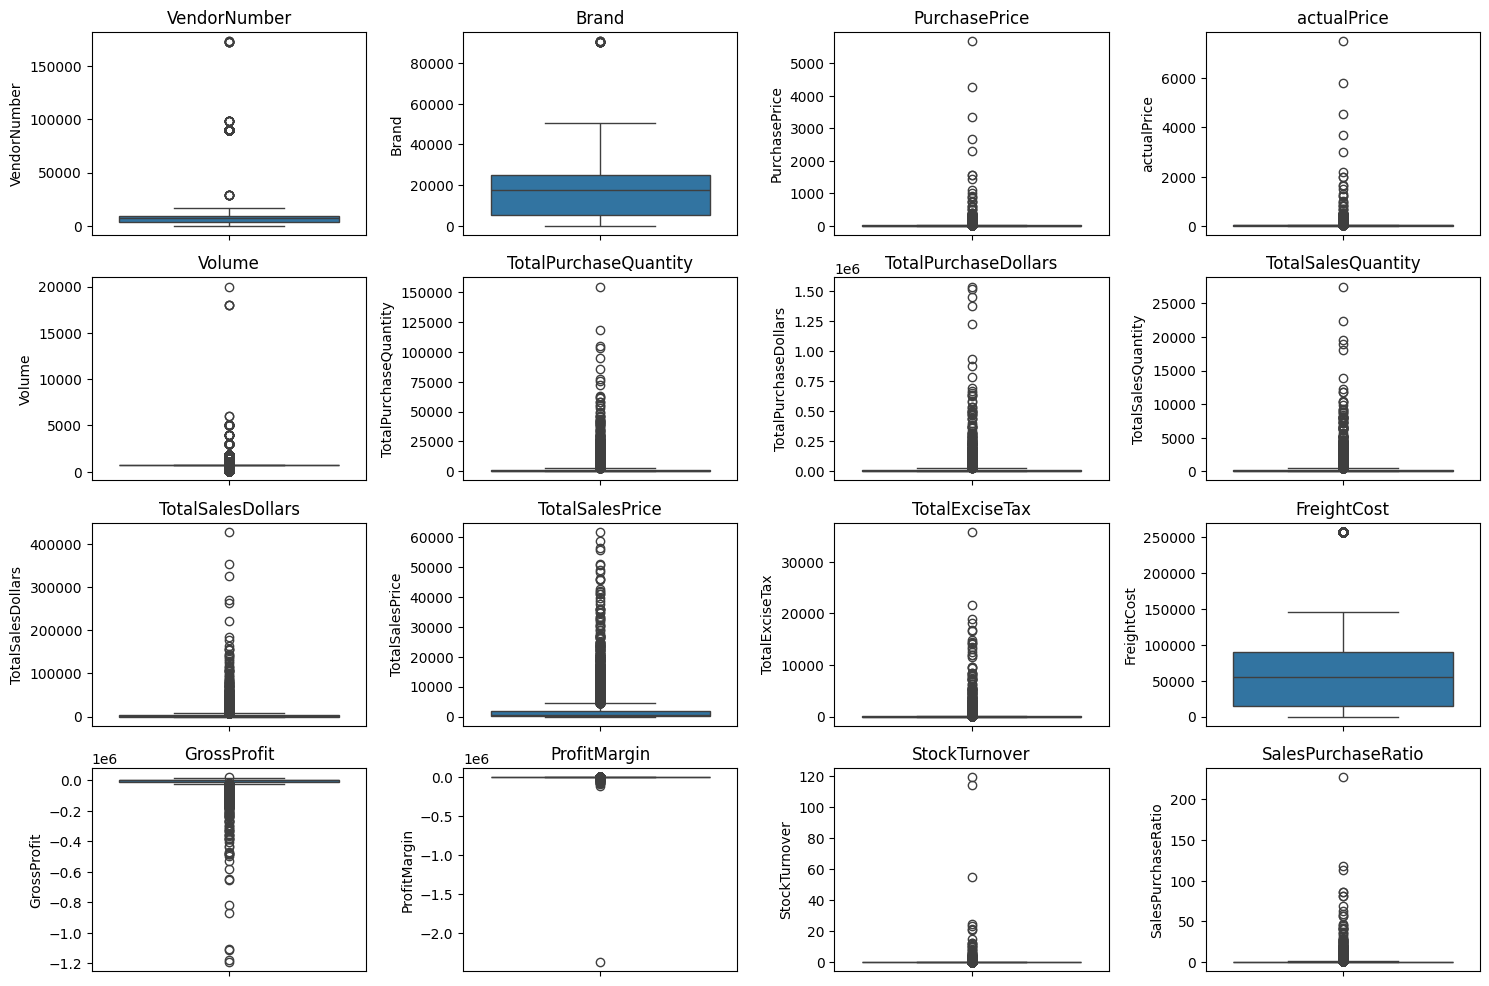

In [15]:
# Finding Outliers
plt.figure(figsize=(15,10))
for i ,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()
    


## Summary Statistics Insights:
Negative and zero values:
1. Gross Profit:Mininum Value is -52,002,indicating losses.Some Products or transactions may be selling at losses due ot high costs or selling discounts lower then the purchase price.
2. Profit  Margin:has min of -infinity ,which suggest case when revenue is 0 or even lower than the cost.
3. Total Sales Quantity and Sales Dollars :Minimum Values are 0 ,meaning products were purchased but never sold.These could be slow moving or obsolte stock.

Outliers Indicated by High Standard Deviations:
1. Purchase and Actual Prices :Max values(5,681.81 &7,499.99) are significantly higher than the mean (24.39&35.64),indicating portential premium products.
2. Freight Cost: Huge Variation ,from 0.09 to 257,032.07 ,suggests logstics inefficiencies or bulk shipment.
3. Stock Turnover:Ranges from 0 to 274.5 ,implying some products sell exetremely fast while others remain in stock indefinitely. Value more than 1 indicates that sold quantity for that products is higher  than purchased quantity due to either sales are being fullfilled from older stock.

In [18]:
# lets filter data by removing inconsistencies
df=pd.read_sql_query("""SELECT * FROM vendor_sales_summary
WHERE "GrossProfit" > 0 AND "ProfitMargin" > 0 AND "TotalSalesQuantity" > 0""",conn)

In [20]:
df_check = pd.read_sql_query("SELECT COUNT(*) FROM vendor_sales_summary", conn)
print(df_check)

   COUNT(*)
0      8488


In [22]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,actualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesPurchaseRatio
0,1392.0,CONSTELLATION BRANDS INC,6650.0,Simi Chard,7.38,14.99,750.0,10892.0,80382.96,8445.0,93130.55,13391.96,948.35,79528.99,12747.59,13.687871,0.105060,1.158586
1,1392.0,CONSTELLATION BRANDS INC,22143.0,Simi Cab Svgn,10.52,18.99,750.0,4017.0,42258.84,2880.0,46362.20,13565.62,322.44,79528.99,4103.36,8.850659,0.068151,1.097101
2,516.0,BANFI PRODUCTS CORP,18152.0,Banfi Centine Mntcln Tscna,5.26,10.99,750.0,5659.0,29766.34,3849.0,31266.51,7418.85,431.47,8510.41,1500.17,4.798009,0.129307,1.050398
3,10754.0,PERFECTA WINES,25197.0,Ch La Rousseliere St Estephe,99.33,149.99,750.0,249.0,24733.17,198.0,29698.02,1199.92,22.24,28720.52,4964.85,16.717781,0.008005,1.200737
4,4425.0,MARTIGNETTI COMPANIES,8781.0,Rodney Strong Cab Svgn,10.32,15.99,750.0,2241.0,23127.12,1827.0,31011.73,11845.02,204.08,144929.24,7884.61,25.424605,0.078998,1.340925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,90024.0,VINILANDIA USA,46135.0,Aresti Pnt Nr Curico Vly,3.28,10.99,750.0,1.0,3.28,15.0,74.85,39.92,1.68,2802.64,71.57,95.617902,4.573171,22.820122
963,9815.0,WINE GROUP INC,8527.0,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2.0,2.64,3.0,5.97,5.97,0.33,27100.41,3.33,55.778894,1.136364,2.261364
964,8004.0,SAZERAC CO INC,5683.0,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6.0,2.34,128.0,62.72,0.98,6.72,50293.62,60.38,96.269133,54.700855,26.803419
965,9815.0,WINE GROUP INC,22407.0,Three Wishes Chard,2.25,3.29,750.0,1.0,2.25,1.0,3.29,3.29,0.11,27100.41,1.04,31.610942,0.444444,1.462222


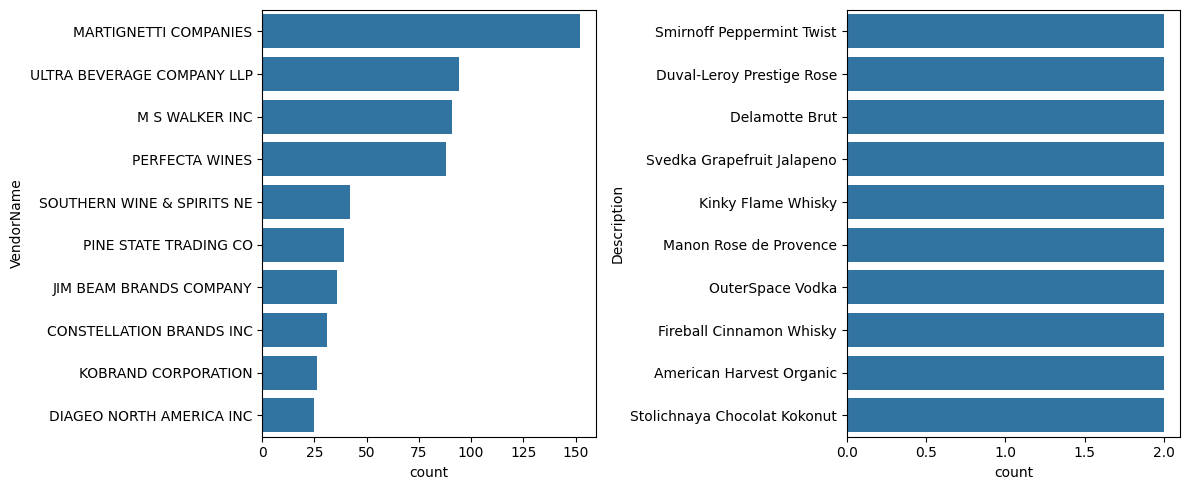

In [24]:
#count plots for categorical Columns
categorical_cols=["VendorName","Description"]
plt.figure(figsize=(12,5))
for i ,col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col],order=df[col].value_counts().index[:10])
plt.tight_layout()
plt.show()
    
    

    

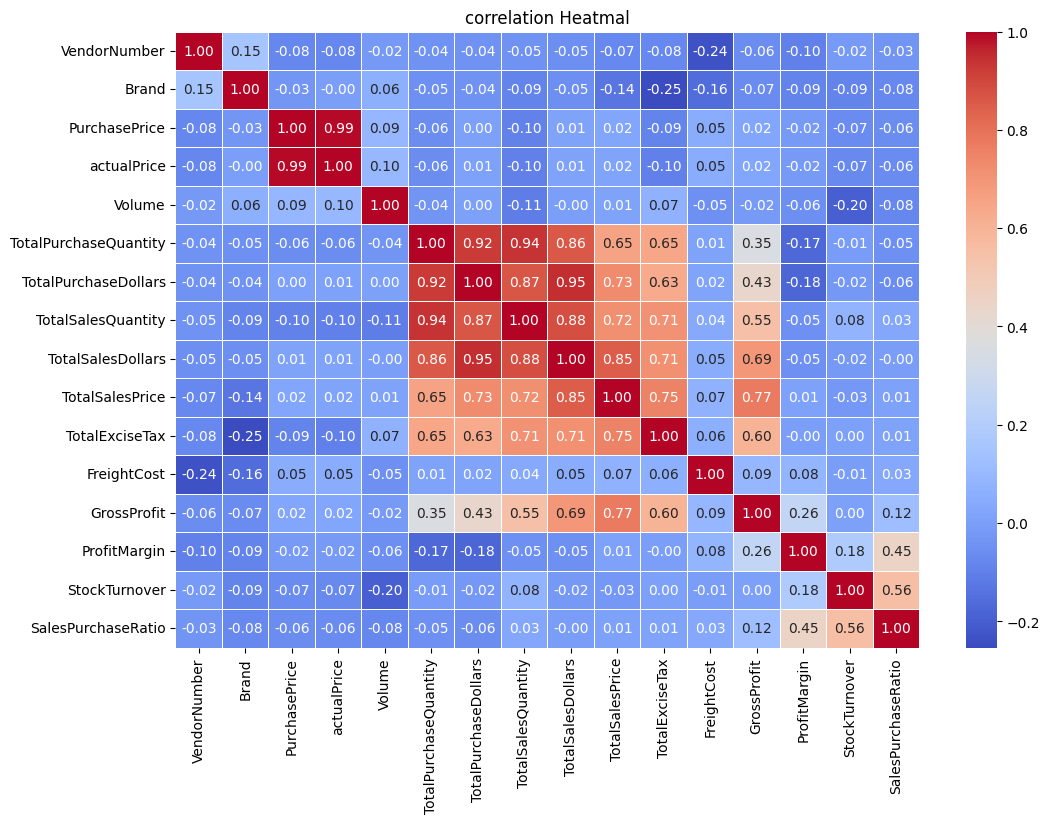

In [59]:
#Correlation
plt.figure(figsize=(12,8))
correlation_matrix=df[numerical_cols].corr()
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidth=0.5)
plt.title("correlation Heatmal")
plt.show()

## Correlation Insights
1. Purchase Price has weak correlations with totalsalesdollars(-0.012) and Gross Profit(-0.016) ,suggesting that  price variations donot significantly impact sales revenue or profit.
2. Strong Correlation between total purchase quantity and total sales quantity (0.999) ,confirming efficient inventory turnover.
3. Negative Correlation between profit  margin and total sales price (-0.179) suggests that as sales price increases,margins decrease ,possibly dut to competitive pricing pressures.
4. Stock Turnover has weak negative correlations with both GrossPorfit (-0.038) and ProfitMargin(-0.0555) ,indicating that faster turnover does not necessarily result in higher profitability.

## Data Analysis  
Identify Brands that needs Promotional or Pricing Adjustments which exihibit lower sales performance but higher profit margins.

In [26]:
#low sales high profit
brand_performance=df.groupby('Description').agg({
    'TotalSalesDollars':'sum','ProfitMargin':'mean'}).reset_index()

In [77]:
brand_performance

,Description,TotalSalesDollars,ProfitMargin
0,12 Days of Pearls Gift Set,259.74,97.231847
1,13th Colony Sthrn Corn Whsky,149.95,89.376459
2,1800 Select Silver Tequila,269.91,69.723241
3,2 Copas Spain White,119.88,33.333333
4,4 Orange Vodka,175.92,61.232378
...,...,...,...
951,Z-52 Znfdl Lodi Old Vines,1262.42,98.766655
952,Zardetto Pros di Coneg Brut,148.23,73.770492
953,Zhenka Vodka 80 Proof,140.64,78.299204
954,Zinsane Znfdl Lodi,8101.86,97.515632


In [28]:
low_sales_threshold=brand_performance['TotalSalesDollars'].quantile(0.15)
High_Margin_threshold=brand_performance['ProfitMargin'].quantile(0.85)

In [30]:
low_sales_threshold
#560 dollar se kam

np.float64(117.08)

In [32]:
High_Margin_threshold
#agar 64 percentage se jayda

np.float64(87.01411643614536)

In [34]:
# filter brand with low sales but high profit margins
target_brands=brand_performance[(
    brand_performance['TotalSalesDollars']<=low_sales_threshold)&
(brand_performance['ProfitMargin']>=High_Margin_threshold)]
print("Brand with Lowe Sales but high Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brand with Lowe Sales but high Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
900,Tracia Syrah,44.94,88.495772
64,Bacardi Oakheart Spiced Trav,59.94,87.554221
270,Chicken & Turkey Cotes du Rh,59.94,90.990991
345,Dr McGillicuddy's Apple Pie,62.72,96.269133
824,St Elder Elderflower Liqueur,66.33,91.436756
46,Aresti Pnt Nr Curico Vly,74.85,95.617902
320,DeKuyper Buttershots Trav,76.93,90.718835
884,Three Olives Grape Vodka,80.19,99.114603
825,St Germain Liqueur,89.94,87.658439
691,Piehole Apple Pie,98.01,95.592287


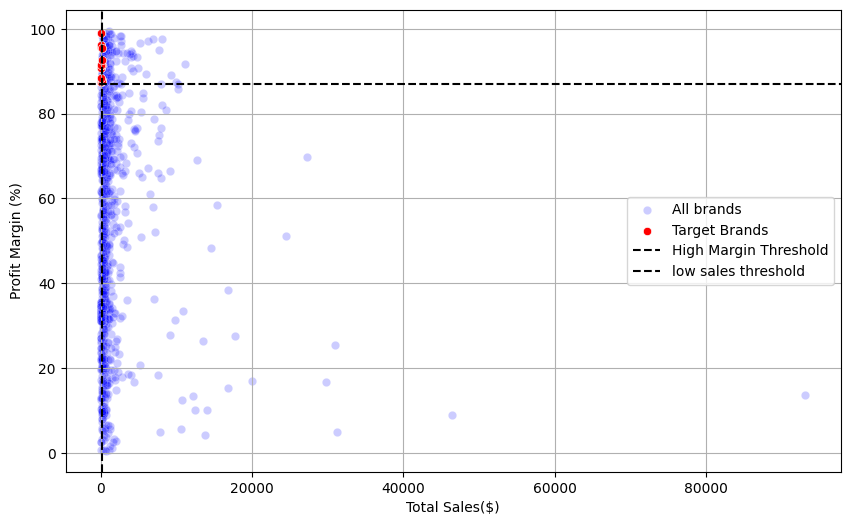

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance,x='TotalSalesDollars',y='ProfitMargin',color="Blue",label="All brands",alpha=0.2)
sns.scatterplot(data=target_brands,x='TotalSalesDollars',y='ProfitMargin',color='Red',label="Target Brands")
plt.axhline(High_Margin_threshold,linestyle='--',color='Black',label="High Margin Threshold")
plt.axvline(low_sales_threshold,linestyle='--',color='black',label="low sales threshold")
plt.xlabel("Total Sales($)")
plt.ylabel("Profit Margin (%)")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
def format_dollars(value):
    if value>=1_00_000:
        return f"{value/1_00_000:.2f}M"
    elif value>=1_000:
        return f"{value/1_00_000:.2f}K"
    else:
        return str(value)

## Which brand and vendors demonstrate the highest sales performance.

In [40]:
top_vendors=df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands=df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)


In [42]:
top_vendors

VendorName
MARTIGNETTI COMPANIES         241276.45
CONSTELLATION BRANDS INC      179641.68
ULTRA BEVERAGE COMPANY LLP    147375.27
M S WALKER INC                116198.82
PERFECTA WINES                111763.75
BACARDI USA INC                63948.20
BROWN-FORMAN CORP              45385.21
SOUTHERN WINE & SPIRITS NE     40225.08
JIM BEAM BRANDS COMPANY        40155.13
STATE WINE & SPIRITS           37680.57
Name: TotalSalesDollars, dtype: float64

In [44]:
top_brands

Description
Simi Chard                      93130.55
Simi Cab Svgn                   46362.20
Banfi Centine Mntcln Tscna      31266.51
Rodney Strong Cab Svgn          31011.73
Ch La Rousseliere St Estephe    29698.02
Buehler Chard RRV               27253.33
Madison's Ranch Cab Svgn        24447.18
Rodney Strong Chard             19912.69
Cava Mistinguett Brut           17753.78
Bacardi Twin Pack 2/750mls      16871.56
Name: TotalSalesDollars, dtype: float64

In [46]:
top_brands.apply(lambda x:format_dollars(x))

Description
Simi Chard                      0.93K
Simi Cab Svgn                   0.46K
Banfi Centine Mntcln Tscna      0.31K
Rodney Strong Cab Svgn          0.31K
Ch La Rousseliere St Estephe    0.30K
Buehler Chard RRV               0.27K
Madison's Ranch Cab Svgn        0.24K
Rodney Strong Chard             0.20K
Cava Mistinguett Brut           0.18K
Bacardi Twin Pack 2/750mls      0.17K
Name: TotalSalesDollars, dtype: object

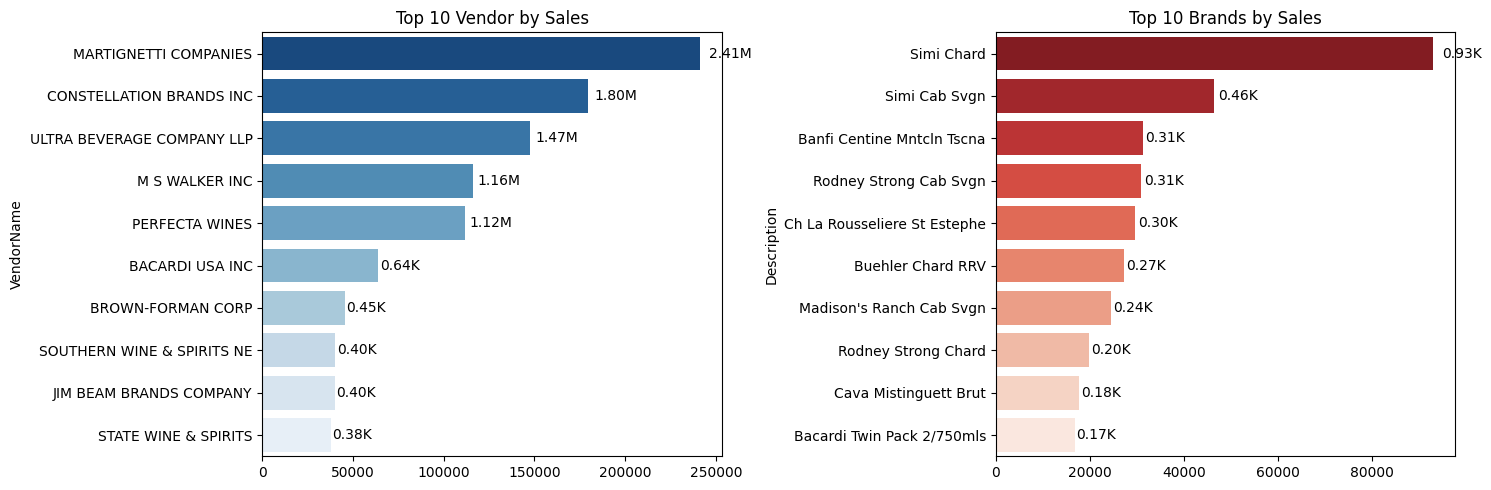

In [48]:
plt.figure(figsize=(15,5))
#plot for top vendors
plt.subplot(1,2,1)
ax1=sns.barplot(y=top_vendors.index,x=top_vendors.values,palette="Blues_r")
plt.title("Top 10 Vendor by Sales")

for bar in ax1.patches:
    ax1.text(
        bar.get_width()+bar.get_width()*0.02,
        bar.get_y()+bar.get_height()/2,
    format_dollars(bar.get_width()),
    ha='left',
    va='center',
    fontsize=10,
    color='black')
#plot for Top Brands
plt.subplot(1,2,2)
ax2=sns.barplot(y=top_brands.index.astype(str),x=top_brands.values,palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width()+bar.get_width()*0.02,bar.get_y()+bar.get_height()/2,
            format_dollars(bar.get_width()),
             ha='left',
             va='center',
             fontsize=10,
             color='black')
plt.tight_layout()
plt.show()

## Which vendors Contribute the most to total purchase Dollars

In [50]:
vendor_performance=df.groupby('VendorName').agg({
    'TotalPurchaseDollars':'sum',
    'GrossProfit':'sum',
    'TotalSalesDollars':'sum'}).reset_index()

In [52]:
vendor_performance['PurchaseContribution%']=vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100

In [54]:
vendor_performance=round(vendor_performance.sort_values('PurchaseContribution%',ascending=False),2)

In [172]:
#Display top 10 vendors
top_vendors=vendor_performance.head(10)
top_vendors['TotalSalesDollars']=top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars']=top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit']=top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,205.76M,-15898226.68,46.78M,15.65
56,MARTIGNETTI COMPANIES,109.28M,-7897435.8,30.30M,8.31
45,JIM BEAM BRANDS COMPANY,104.25M,-8008905.61,24.16M,7.93
67,PERNOD RICARD USA,95.43M,-7421176.87,21.22M,7.26
6,BACARDI USA INC,68.97M,-5284347.86,16.13M,5.25
20,CONSTELLATION BRANDS INC,66.18M,-4791410.39,18.27M,5.03
11,BROWN-FORMAN CORP,59.06M,-4615408.71,12.90M,4.49
104,ULTRA BEVERAGE COMPANY LLP,54.05M,-4044301.99,13.60M,4.11
30,E & J GALLO WINERY,52.09M,-3724207.16,14.85M,3.96
52,M S WALKER INC,43.91M,-3141576.06,12.49M,3.34


In [58]:
 top_vendors['PurchaseContribution%'].sum()

np.float64(75.02)

In [174]:
top_vendors['Cumulative_Contribution%']=top_vendors['PurchaseContribution%'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,205.76M,-15898226.68,46.78M,15.65,15.65
56,MARTIGNETTI COMPANIES,109.28M,-7897435.8,30.30M,8.31,23.96
45,JIM BEAM BRANDS COMPANY,104.25M,-8008905.61,24.16M,7.93,31.89
67,PERNOD RICARD USA,95.43M,-7421176.87,21.22M,7.26,39.15
6,BACARDI USA INC,68.97M,-5284347.86,16.13M,5.25,44.40
20,CONSTELLATION BRANDS INC,66.18M,-4791410.39,18.27M,5.03,49.43
11,BROWN-FORMAN CORP,59.06M,-4615408.71,12.90M,4.49,53.92
104,ULTRA BEVERAGE COMPANY LLP,54.05M,-4044301.99,13.60M,4.11,58.03
30,E & J GALLO WINERY,52.09M,-3724207.16,14.85M,3.96,61.99
52,M S WALKER INC,43.91M,-3141576.06,12.49M,3.34,65.33


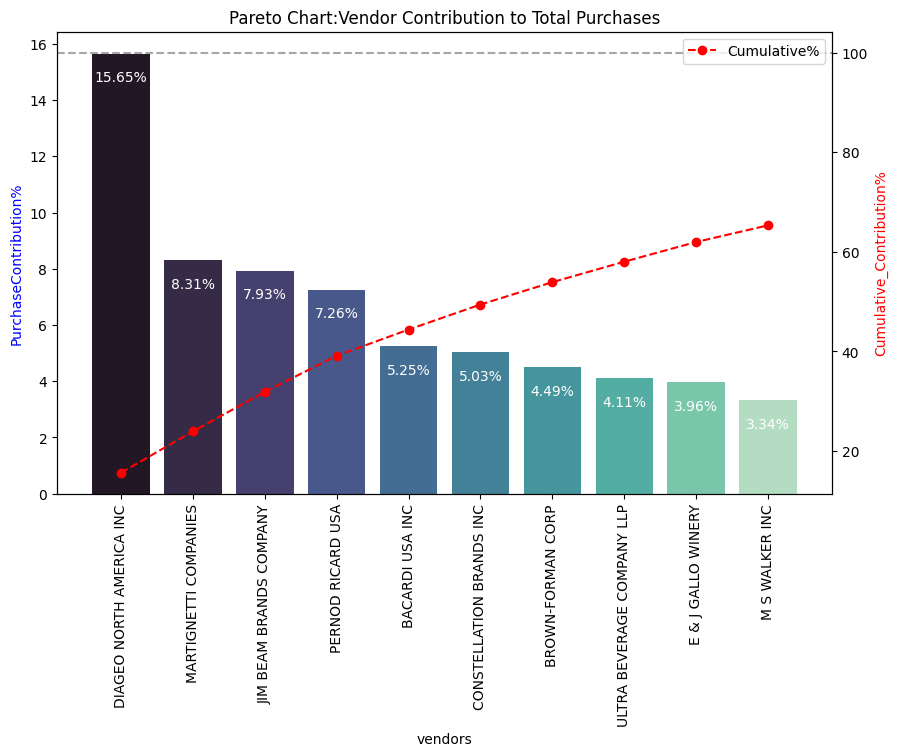

In [176]:
fig,ax1=plt.subplots(figsize=(10,6))
#Bar plot for purchase Contribution%
sns.barplot(x=top_vendors['VendorName'],y=top_vendors['PurchaseContribution%'],palette="mako",ax=ax1)
for i ,value in enumerate(top_vendors['PurchaseContribution%']):
    ax1.text(i,value-1,str(value)+'%',ha='center',fontsize=10,color='white')
#Line Plot for Cummulative Contributions
ax2=ax1.twinx()
ax2.plot(top_vendors['VendorName'],top_vendors['Cumulative_Contribution%'],color='Red',marker='o',linestyle='--',label='Cumulative%')
ax1.set_xticklabels(top_vendors['VendorName'],rotation=90)
ax1.set_ylabel('PurchaseContribution%',color='blue')
ax2.set_ylabel('Cumulative_Contribution%',color='red')
ax1.set_xlabel('vendors')
ax1.set_title('Pareto Chart:Vendor Contribution to Total Purchases')
ax2.axhline(y=100,color='gray',linestyle='--',alpha=0.7)
ax2.legend(loc='upper right')
plt.show() 

## How much of total procurement is dependent on the top Vendors?

In [178]:
print(f"Total Purchase Contribution of Top 10 Vendors is {round(top_vendors['PurchaseContribution%'].sum(),2)}%")


Total Purchase Contribution of Top 10 Vendors is 65.33%


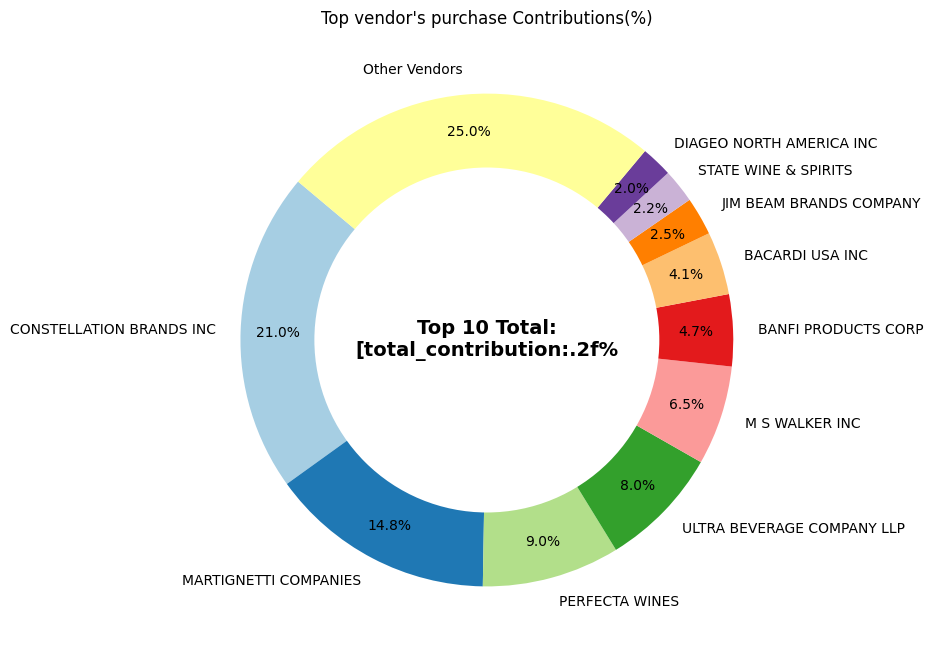

In [64]:
#Donat Chart
vendors=list(top_vendors['VendorName'].values)
purchase_contributions=list(top_vendors['PurchaseContribution%'].values)
total_contribution=sum(purchase_contributions)
remaining_contribution=100-total_contribution

#append "other vendor Category"
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)
# for chart
fig,ax=plt.subplots(figsize=(8,8))
wedges,texts,autotexts=ax.pie(purchase_contributions,labels=vendors,autopct='%1.1f%%',
                              startangle=140,pctdistance=0.85,colors=plt.cm.Paired.colors)
#Draw a white circle in the center to create a donut effect
center_circle=plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(center_circle)

plt.text(0,0,f"Top 10 Total:\n[total_contribution:.2f%",fontsize=14,fontweight='bold',ha='center',va='center')
plt.title("Top vendor's purchase Contributions(%)")
plt.show()

## Does purchasing in bulk reduce the unit price ,and what is the optimal purchase volumne of cost savings?

In [66]:
df['UnitPurchasePrice']=df['TotalPurchaseDollars']/df['TotalPurchaseQuantity']

In [51]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,actualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesPurchaseRatio,UnitPurchasePrice
0,3960.0,DIAGEO NORTH AMERICA INC,4261.0,Capt Morgan Spiced Rum,16.17,22.99,1750.0,95004.0,1536214.68,19486.0,428528.14,41432.16,35804.05,257032.07,-1107686.54,-258.486302,0.012684,0.278951,16.17
1,1128.0,BROWN-FORMAN CORP,1233.0,Jack Daniels No 7 Black,26.27,36.99,1750.0,57735.0,1516698.45,9080.0,326789.20,61614.88,16683.12,68601.68,-1189909.25,-364.121351,0.005987,0.215461,26.27
2,4425.0,MARTIGNETTI COMPANIES,3405.0,Tito's Handmade Vodka,23.19,28.99,1750.0,62385.0,1446708.15,9052.0,270781.48,50459.13,16631.68,144929.24,-1175926.67,-434.271454,0.006257,0.187171,23.19
3,17035.0,PERNOD RICARD USA,8068.0,Absolut 80 Proof,18.24,24.99,1750.0,75385.0,1375022.40,10243.0,264494.57,45628.33,18819.83,123780.22,-1110527.83,-419.867913,0.007449,0.192357,18.24
4,3960.0,DIAGEO NORTH AMERICA INC,3545.0,Ketel One Vodka,21.89,29.99,1750.0,55834.0,1222206.26,11765.0,354214.35,51029.09,21616.83,257032.07,-867991.91,-245.047077,0.009626,0.289816,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8483,9815.0,WINE GROUP INC,8527.0,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2.0,2.64,3.0,5.97,5.97,0.33,27100.41,3.33,55.778894,1.136364,2.261364,1.32
8484,8004.0,SAZERAC CO INC,5683.0,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6.0,2.34,128.0,62.72,0.98,6.72,50293.62,60.38,96.269133,54.700855,26.803419,0.39
8485,9815.0,WINE GROUP INC,22407.0,Three Wishes Chard,2.25,3.29,750.0,1.0,2.25,1.0,3.29,3.29,0.11,27100.41,1.04,31.610942,0.444444,1.462222,2.25
8486,3960.0,DIAGEO NORTH AMERICA INC,3775.0,Smirnoff Sorbet Pine/Coconut,0.73,0.99,50.0,1.0,0.73,0.0,0.00,0.00,0.00,257032.07,-0.73,-inf,0.000000,0.000000,0.73


In [68]:
df["OrderSize"]=pd.qcut(df["TotalPurchaseQuantity"],q=3,labels=["Small","Medium","Large"])

In [65]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,actualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,...,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesPurchaseRatio,UnitPurchasePrice,Order Size,OrderSize
0,3960.0,DIAGEO NORTH AMERICA INC,4261.0,Capt Morgan Spiced Rum,16.17,22.99,1750.0,95004.0,1536214.68,19486.0,...,41432.16,35804.05,257032.07,-1107686.54,-258.486302,0.012684,0.278951,16.17,Large,Large
1,1128.0,BROWN-FORMAN CORP,1233.0,Jack Daniels No 7 Black,26.27,36.99,1750.0,57735.0,1516698.45,9080.0,...,61614.88,16683.12,68601.68,-1189909.25,-364.121351,0.005987,0.215461,26.27,Large,Large
2,4425.0,MARTIGNETTI COMPANIES,3405.0,Tito's Handmade Vodka,23.19,28.99,1750.0,62385.0,1446708.15,9052.0,...,50459.13,16631.68,144929.24,-1175926.67,-434.271454,0.006257,0.187171,23.19,Large,Large
3,17035.0,PERNOD RICARD USA,8068.0,Absolut 80 Proof,18.24,24.99,1750.0,75385.0,1375022.40,10243.0,...,45628.33,18819.83,123780.22,-1110527.83,-419.867913,0.007449,0.192357,18.24,Large,Large
4,3960.0,DIAGEO NORTH AMERICA INC,3545.0,Ketel One Vodka,21.89,29.99,1750.0,55834.0,1222206.26,11765.0,...,51029.09,21616.83,257032.07,-867991.91,-245.047077,0.009626,0.289816,21.89,Large,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8483,9815.0,WINE GROUP INC,8527.0,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2.0,2.64,3.0,...,5.97,0.33,27100.41,3.33,55.778894,1.136364,2.261364,1.32,Small,Small
8484,8004.0,SAZERAC CO INC,5683.0,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6.0,2.34,128.0,...,0.98,6.72,50293.62,60.38,96.269133,54.700855,26.803419,0.39,Small,Small
8485,9815.0,WINE GROUP INC,22407.0,Three Wishes Chard,2.25,3.29,750.0,1.0,2.25,1.0,...,3.29,0.11,27100.41,1.04,31.610942,0.444444,1.462222,2.25,Small,Small
8486,3960.0,DIAGEO NORTH AMERICA INC,3775.0,Smirnoff Sorbet Pine/Coconut,0.73,0.99,50.0,1.0,0.73,0.0,...,0.00,0.00,257032.07,-0.73,-inf,0.000000,0.000000,0.73,Small,Small


In [70]:
df[['OrderSize','TotalPurchaseQuantity']]

,OrderSize,TotalPurchaseQuantity
0,Large,10892.0
1,Large,4017.0
2,Large,5659.0
3,Large,249.0
4,Large,2241.0
...,...,...
962,Small,1.0
963,Small,2.0
964,Small,6.0
965,Small,1.0


In [72]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,36.107708
Medium,20.614216
Large,11.312885


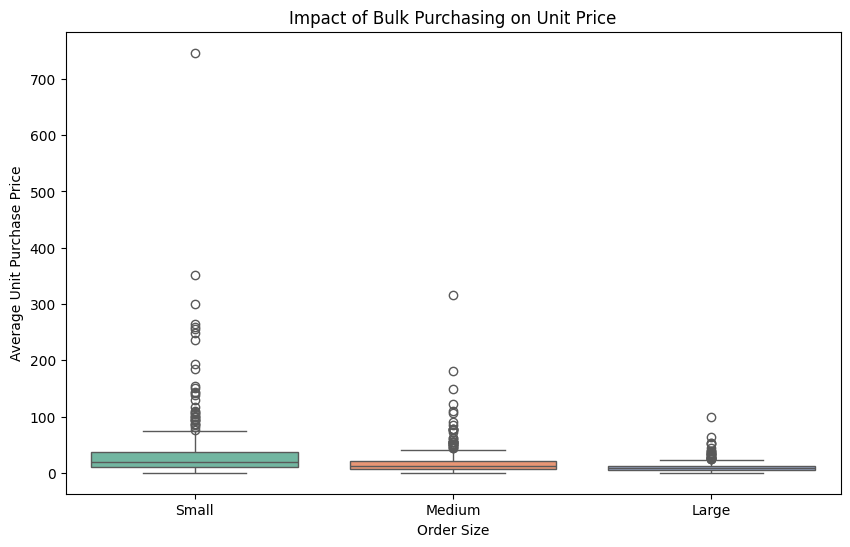

In [74]:
#means more the bulk the less is the unitprice so will will plot using box plot
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x="OrderSize",y="UnitPurchasePrice",palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

1. Vendors buying in bulk (large size order) get the lowest unit price($10.78 per unit ),meaning higher margins if they can manage inventory efficiently.
2. The price difference between small and large orders is substaintial (72% reduction in unit cost)
3. This suggests that bulk  pricing strategies successfully encourage vendors to purchase in larger volumne,leading to higher overall sales despite lower per unit revenue.

## Which vendors have low inventory turnover,indicating excess stock and slow moving products?

In [76]:
#Stock Turn over means how may times your stock was sold and replaced in given period of time.
df[df['StockTurnover']<1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover',ascending=True).head(10)  # less tha 1 means they sell less than 1 cycle of their stock -very low sales or excess stock

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.033403
VRANKEN AMERICA,0.034837
ATLANTIC IMPORTING COMPANY,0.040297
EDRINGTON AMERICAS,0.044331
STE MICHELLE WINE ESTATES,0.054705
SEA BREEZE CELLARS LLC,0.056402
WILLIAM GRANT & SONS INC,0.057400
MOET HENNESSY USA INC,0.057400
R.P.IMPORTS INC,0.061264


## How much inventory is unsold inventory per vendor ,and which vendors contribute most to it? 

In [78]:
df['UnsoldInventoryValue']=(df['TotalPurchaseQuantity']-df['TotalSalesQuantity'])*df["PurchasePrice"] #unsold quantity*purchasePrice
print('Total Unsold Capital:',format_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital: -253615.46000000002


In [102]:
#Aggregated Capital Locked per Vendor
inventory_value_per_vendor=df.groupby("VendorName")["UnsoldInventoryValue"].sum().sort_values(ascending=False).reset_index()
#Sort Vendors with higest Locked Capital
inventory_value_per_vendor=inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue",ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue']=inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
0,DIAGEO NORTH AMERICA INC,172.35M
1,MARTIGNETTI COMPANIES,90.18M
2,JIM BEAM BRANDS COMPANY,86.58M
3,PERNOD RICARD USA,80.32M
4,BACARDI USA INC,57.86M
5,CONSTELLATION BRANDS INC,55.25M
6,BROWN-FORMAN CORP,49.98M
7,ULTRA BEVERAGE COMPANY LLP,44.96M
8,E & J GALLO WINERY,42.71M
9,M S WALKER INC,35.68M


## What is the 95% confidence interval for profit marginsof top performing and low-performing vendors.

In [180]:
# Set Threshold
top_threshold=df["TotalSalesDollars"].quantile(0.75)
low_threshold=df["TotalSalesDollars"].quantile(0.25)

In [182]:
top_vendors=df[df["TotalSalesDollars"]>=top_threshold]["ProfitMargin"].dropna()
low_vendors=df[df["TotalSalesDollars"]<=low_threshold]["ProfitMargin"].dropna()

In [184]:
top_vendors


0      -258.486302
1      -364.121351
2      -434.271454
3      -419.867913
4      -245.047077
           ...    
6947     97.515632
6960     94.254370
7092     96.604131
7105     97.525774
7114     97.250949
Name: ProfitMargin, Length: 2122, dtype: float64

In [125]:
low_vendors

15     -2.366722e+06
298             -inf
335             -inf
442             -inf
550             -inf
            ...     
8480            -inf
8482   -4.949495e+01
8483    5.577889e+01
8485    3.161094e+01
8486            -inf
Name: ProfitMargin, Length: 2122, dtype: float64

In [137]:
def confidence_interval(data,confidence=0.95):
    mean_val=np.mean(data)
    std_err=np.std(data,ddof=1)/np.sqrt(len(data))
    t_critical=stats.t.ppf((1+confidence)/2,df=len(data)-1)
    margin_of_error=t_critical*std_err
    return mean_val,mean_val-margin_of_error,mean_val+margin_of_error

Top Vendors 95% CI:(-294.63,-279.41),Mean:-287.02
Low Vendors 95% CI:(nan,nan),Mean:-inf


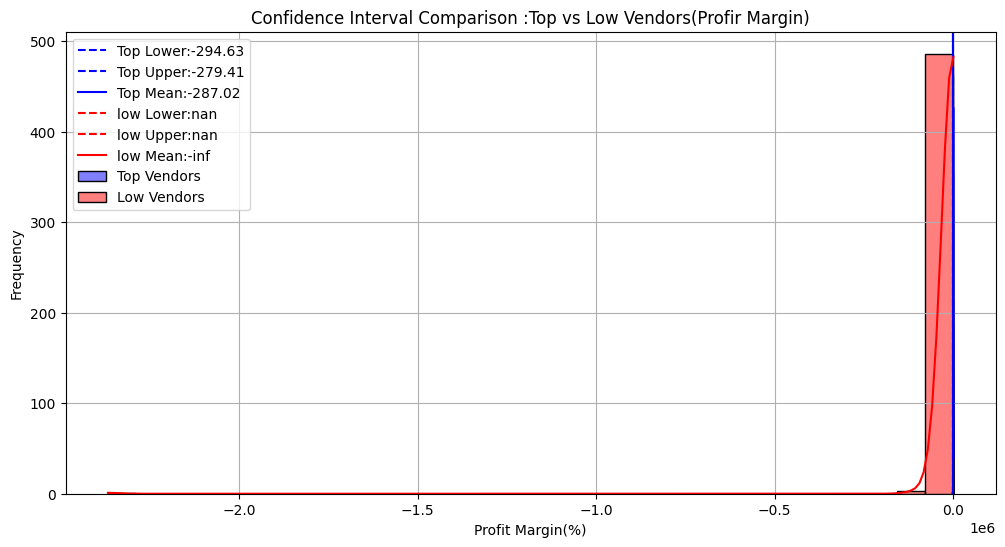

In [157]:
top_mean,top_lower,top_upper=confidence_interval(top_vendors)
low_mean,low_lower,low_upper=confidence_interval(low_vendors)
print(f"Top Vendors 95% CI:({top_lower:.2f},{top_upper:.2f}),Mean:{top_mean:.2f}")
print(f"Low Vendors 95% CI:({low_lower:.2f},{low_upper:.2f}),Mean:{low_mean:.2f}")
plt.figure(figsize=(12,6))
#Top Vendors Plot
sns.histplot(top_vendors,kde=True,color="blue",bins=30,alpha=0.5,label="Top Vendors")
plt.axvline(top_lower,color='Blue',linestyle='--',label=f"Top Lower:{top_lower:.2f}")
plt.axvline(top_upper,color='Blue',linestyle='--',label=f"Top Upper:{top_upper:.2f}")
plt.axvline(top_mean,color='Blue',linestyle='-',label=f"Top Mean:{top_mean:.2f}")


#low vendor plot
sns.histplot(low_vendors,kde=True,color="red",bins=30,alpha=0.5,label="Low Vendors")
plt.axvline(low_lower,color='red',linestyle='--',label=f"low Lower:{low_lower:.2f}")
plt.axvline(low_upper,color='red',linestyle='--',label=f"low Upper:{low_upper:.2f}")
plt.axvline(low_mean,color='red',linestyle='-',label=f"low Mean:{low_mean:.2f}")

#Finalize Plot
plt.title("Confidence Interval Comparison :Top vs Low Vendors(Profir Margin)")
plt.xlabel("Profit Margin(%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

1. Vendor with low sales tend to maintain higher profit margins,potentially due to premium pricing or lower oprational costs.
2. for high performing vendors:if they aim to improve Profitability,they could explore selective price adjustments ,cost optimization  or bundling strategies.
3. for low performing vendors:Despite higher margins ,their low sales column might indicate a need for better marketing ,competitive pricing or improve distribution strategies.

# is this a significant diffrence in profit margins between top-performing and low performing vendors?
hypothesis:

H(Null Hupothesis)=There is no significant diffrence in the mean profit margins of top performing and low  performing vendors.

H(Alternative Hypothesis)=The Mean profit  margins of top performing and lowe performing vendors are significantly different.

In [170]:
top_threshold=df["TotalSalesDollars"].quantile(0.75)
low_threshold=df["TotalSalesDollars"].quantile(0.25)

top_vendors=df[df["TotalSalesDollars"]>=top_threshold]["ProfitMargin"].dropna()
low_vendors=df[df["TotalSalesDollars"]<=low_threshold]["ProfitMargin"].dropna()

#perform  two sample t test
t_stat,p_value=ttest_ind(top_vendors,low_vendors,equal_var=False)
#Prints results
print(f"T-Statistic:{t_stat:.4f},P-value:{p_value:.4f}")
if p_value<0.05:
    print("Reject Ho:There is a significant diffrence in the mean profit margins of top performing and low  performing vendors.")
else:
    print("Fail to reject Ho:No significant difference in profit margin of top performing and lowe performing vendors are significantly different.")

T-Statistic:nan,P-value:nan
Fail to reject Ho:No significant difference in profit margin of top performing and lowe performing vendors are significantly different.
